In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join('..'))
from model import GreyboxModel

# load experiment parameters
exptname = 'reaction-diffusion'
trialname = 'demo'
mode = 'adaptive'
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params = yaml.safe_load(fd)

### Preparation

In [2]:
# load log
with np.load(os.path.join('..', 'out', trialname, mode, 'curve_tr.npz')) as data:
    L_tr = data['L_tr']
    L_va = data['L_va']

# load test data
with np.load(os.path.join('..', 'out', trialname, 'data_te.npz')) as data:
    x = data['x']
    y = data['y']

# load model
model = GreyboxModel(params['model'])
model.load_state_dict(torch.load(os.path.join('..', 'out', trialname, mode, 'model_te.pt')))
model.eval()

GreyboxModel(
  (net_fD): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
  (net_zD_encoder): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=16, bias=True)
  )
  (net_thT_encoder): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): Leak

### Inspect learning curves

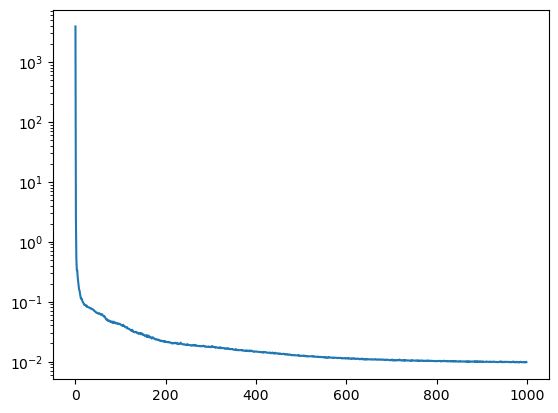

In [3]:
epochs_tr = np.array(list(range(0, L_tr.shape[0])))
# epochs_va = np.array(list(range(0, L_tr.shape[0], params['train']['valid_interval_epochs'])))

plt.plot(epochs_tr, np.mean(L_tr, axis=1))
# plt.plot(epochs_va, np.mean(L_va, axis=1))
plt.yscale('log')
# plt.legend(['train', 'validation'])
plt.show()

### Prediction example

In [4]:
# prediction on test data
with torch.no_grad():
    _x = torch.tensor(x).float()
    yh, R = model(_x)
    thT = model.thT_encode(_x)
yh = yh.detach().numpy()
thT = thT.detach().numpy()

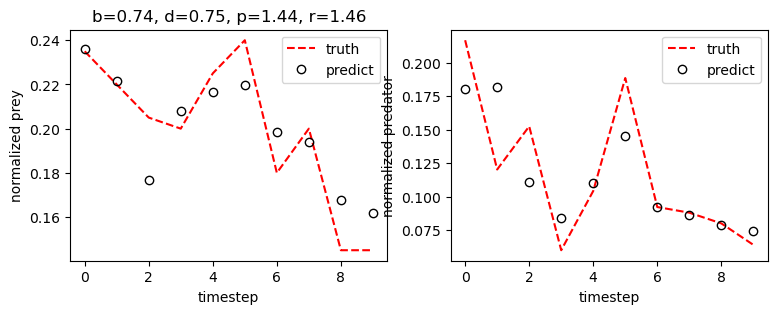

In [5]:
# plot
sample_idx = 10

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ylabels = ['normalized prey', 'normalized predator']
for i in [0,1]:
    ax[i].plot(y[sample_idx,:,i], '--', color='red')
    ax[i].plot(yh[sample_idx,:,i], 'o', color='black', markerfacecolor='none')
    ax[i].set_xlabel('timestep')
    ax[i].set_ylabel(ylabels[i])
    ax[i].legend(('truth', 'predict'))
    # ax[i].set_ylim([0.0, 0.8])
    ax[0].set_title('b=%0.2f, d=%0.2f, p=%0.2f, r=%0.2f'%(
        thT[sample_idx , 0],
        thT[sample_idx, 1],
        thT[sample_idx, 2],
        thT[sample_idx, 3]
    ))
plt.show()


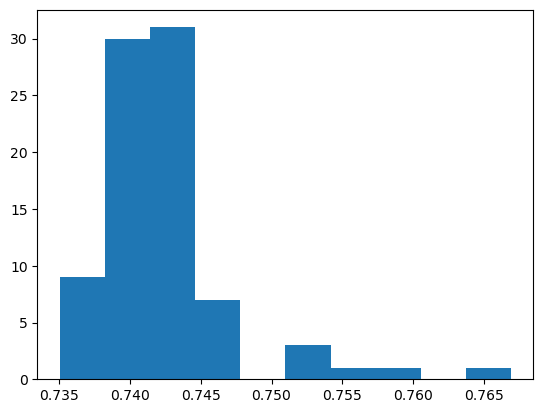

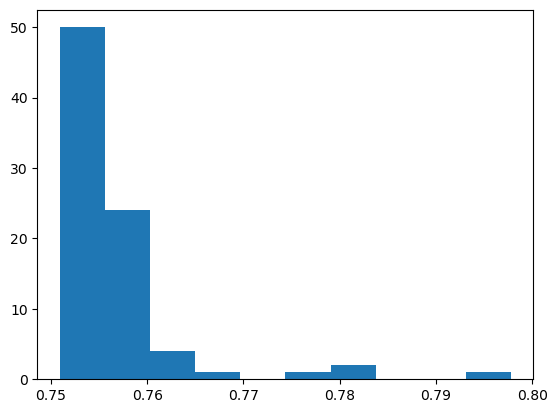

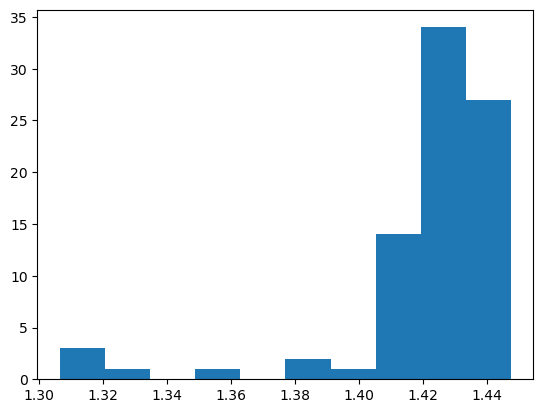

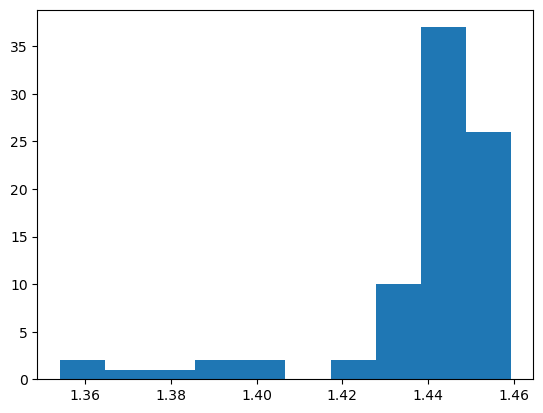

In [6]:
for i in range(4):
    plt.figure()
    plt.hist(thT[:,i])
    plt.show()